In [1]:
import warnings
warnings.filterwarnings('ignore')

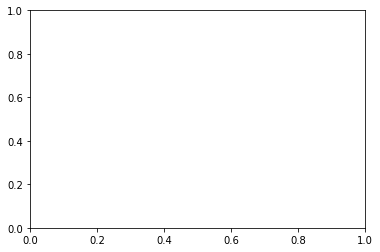

In [2]:
from plotting_utils import *
from model_test_cases import *


Title
- Abstract
- Introduction
- Materials and methods or Description of the Model - Results
- Discussion
- Conclusions and Summary (optional)
- Acknowledgements (optional) - References
- Appendix (optional)


# A model for two mice in a small cage

## Introduction

## Problem statement: Two mice in a cage

The problem given to us was:

<a name="P1"></a>P1. We have two mice in a cage (in a 2-D or 1-D field).

<a name="P2"></a>P2. They don't like each other.

<a name="P3"></a>P3. Food is present in one given spot in the cage.

<a name="P4"></a>P4. There is only enough space for one mouse to eat at a time.

<a name="P5"></a>P5. They need to reproduce.

<a name="P6"></a>P6. They don't reproduce where they eat.

<a name="P7"></a>P7. After being full, mice don't find the feeding spot that attractive anymore.

We are interested in trajectories of the two mice.

## Assumptions

The problem description brings many details that can be modeled. A model taking every detail into consideration
can become quickly very complex.
Moreover, the profundity of biological details can become overwhelming very quickly.

For exemplification, however, we want to have a simplistic model that takes into consideration a couple of key aspects
of the problem and ignores the rest.

Therefore, I will ignore some aspects specified in the problem description and will generalize over some biological
details.


### <a name="A1"></a>A1. The cage

I will assume the mice move inside idealized cages with infinitely high walls such that the mice are not influenced
in any ways by the outside world.
The system is, thus, closed. Therefore, it's state dynamics depends only on variables that can be found inside
the cage and we have access to during the modelling task.

I will also assume one can observe the mice from above in an idealized way.
This means we always have access to their exact position and this reading is done noise free.

### <a name="A2"></a>A2. Biological variability of the mice physiology

As previously mentioned, I will assume that the actual physical biology of the mice is irrelevant for the problem at hand.
One could look for biologically plausible movement model of the mouse, in which arms, legs, joins, body and head geometry
are considered. However, I do not expect the quality of the desired outputted trajectories to improve dramatically.

As a consequence, in the attempt to keep complexity low, I will idealize the 2 mice inside a cage to point particles
that obey a system of coupled and nonlinear stochastic differential equations.

### <a name="A3"></a>A3. Movement of the mice

The problem does not express it explicitly, but I will assume that mice usually like exploring their
environments and are quite curious.
Abstracting over internal


### <a name="A4"></a>A4. Mating

Similarly to previous decisions, I will ignore many biologically plausible details, with 2 exceptions:

<a name="A4_1"></a>A4.1. I will assume there is a periodicity in the mating schedule, but keep this very basic.

<a name="A4_2"></a>A4.2. I will assume that proximity to the other mouse produces arousal i.e. even more desire to mate.


### <a name="A5"></a>A5. Feeding spot

The problem description does not come with many details about feeding. Therefore, I will try to keep feeding as
simple as possible.

I will assume that:

1. food is present in abundance for the mice.
2. there is no feeding schedule or any fixed time window in which feeding can be done.
3. mice are able to feed if they are close enough (a set radius distance apart) from the feeding spot.

As a consequence, infinite amount of food will be **always** present in the cage.
This means that the mice can feed as much and as often as they want.

### Details ignored from the problem description

#### 1. There is only enough space for one mouse to eat at a time
I will ignore *([P4](#P4))* from the problem description.
The reasoning is:
1. to the limit $\lim_{dt \rightarrow 0}$ two simultaneous feeding events are mathematically not possible.
2. this implies we can always find a small enough discretization s.t. two simultaneous are mathematically excluded.


Moreover, I ignore the fact the mice **might** get hungrier if they are close to the food spot
because the problem does not state this. Rather, the assumption is that they know how to navigate their environment
and they, somehow, **remember** the spot of the food.

#### 2. They don't reproduce where they eat
After implementing *(P1-P3), (P5), (P7)* I decided to ignore this detail to keep complexity low.
In the [discussions](#Discussion) section I will suggest how to add this aspect.

## Methods
My target is to obtain a system of couples differential equations.


### Closed form or simulation ?
Typically, mice take many decisions at each time step randomly, what for the outside observer might appear as totally random.
As a simplification, we can bundle all these random decisions in one stochastic process.

As a consequence, our system of differential equations becomes a system of **stochastic differential equations**.

Therefore, finding a closed form is very difficult, if not impossible.
I will concentrate in this report on simulating the model on a computer and not think about a
closed form solution of our model.

### Euler-Maruyama
Dynamical systems can be easily implemented using the **Forward Euler** method. This takes into
account the first order Taylor polynomial expansion.

Due to the system of coupled SDEs, simple **Forward Euler** will not work. The reason is the modelled
stochastic process must have a variance that has to be adapted to the chosen discretization step, usually denoted $\Delta_t$.
This method is called  **Euler-Maruyama** and is an extension of the **Forward Euler**
method [see [more details](#Movement-Model)].

Because it is very simple to implement, I will code the **Euler-Maruyama** integration scheme directly and
not use any external libraries.

### Splitting the problem into smaller ones

A dynamical system of differential equations can be seen as a gradient descent on an energy landscape.

Taking advantage of the fact that gradients are a vector field, we can actually split the problem into smaller ones.
At the end we will be able to recover full expressivity of the model by linearly adding up these components.

This is particularly advantageous when implementing the model because it allows me to split the problem into smaller ones,
that have manageable complexity.

Therefore, I will subsequently present, in isolation three models:
1. a movement model
2. a mating model
3. a feeding model

Our final model, the Mouse Model will be composed of the mentioned three models.

#### Movement Model

Implementing  [P1](#P1) , [A2](#A2) and [A3](#A3) (i.e. 2-d movement, point particles, mice are exploring)
I find appropriate a brownian movement with white noise model. The component
of the movement model in the system of SDEs the becomes:

$$ \tau_{mouse}\frac{d\vec{m}}{dt} = \sigma_{mouse}\cdot\vec{\xi(t)}  \ \ (1) $$

where $ \vec{\xi(t)} \sim \mathcal{\vec{N}}(0,1)\$ is called noise.


The noise model I chose is gaussian white-noise, which is defined by the following two properties:

<a name="N1"></a>Noise 1. $<\vec{\xi_t} >  = \vec{0}$

<a name="N2"></a>Noise 2. $<\xi_t \cdot \xi_t' >  = \delta(t-t')$

where $\delta(t)$ is the **Dirac delta** generalized function.
The **Dirac delta** has the very important property that <a name="r_2"></a>$\int_{-\infty}^{\infty}\delta(t)dt=1 \ \ (2) $.


By multiplying both sides of eq. (1) with $dt$ we obtain:

$$ \tau_{mouse}d\vec{m} = \sigma_{mouse}\cdot dt \cdot \vec {\xi(t)} = \sigma_{mouse} \cdot dW_t \ \ (3) $$


Eq. (3) is
known in the literature as an Ornstein-Uhlenbeck stochastic process, $dW_{t}$ being its kernel.

Because we have to simulate the time evolution on a computer, we have to choose a discretization for our simulation
$dt \mapsto \Delta t $. Thus, we have [(Noise 2.)](#N2) in discrete form:
$<\xi_{\Delta t} \cdot \xi_{\Delta t}> = \frac {1}{\Delta t} $ to fulfill property [(2)](#r_2) of the Dirac delta.

As a consequence, we require
$<\Delta W_{t}^2> = <\Delta\xi_{t}^2 \cdot \Delta t ^2>= \Delta t ^2 \cdot <\Delta\xi_{t}^2>=\frac{\Delta t ^2}{\Delta t}
= \Delta t$.

(3) thus becomes:
$ \tau_{mouse} \Delta \vec{m} = \sigma_{mouse} \cdot \ \sqrt {\Delta t} \cdot \vec {\xi_t} $ from which it follows that

$$ \tau_{mouse} \Delta \vec{m}_{movement} \sim \mathcal{N}(0,\,\sigma_{mouse}^{2}\cdot\Delta t)\ \ \ (4) $$

We can implement relationship (4) directly using the mentioned **Euler-Maruyama** scheme.

##### Typical trajectories

The 2-D brownian movement model produces, then, trajectories similar to:

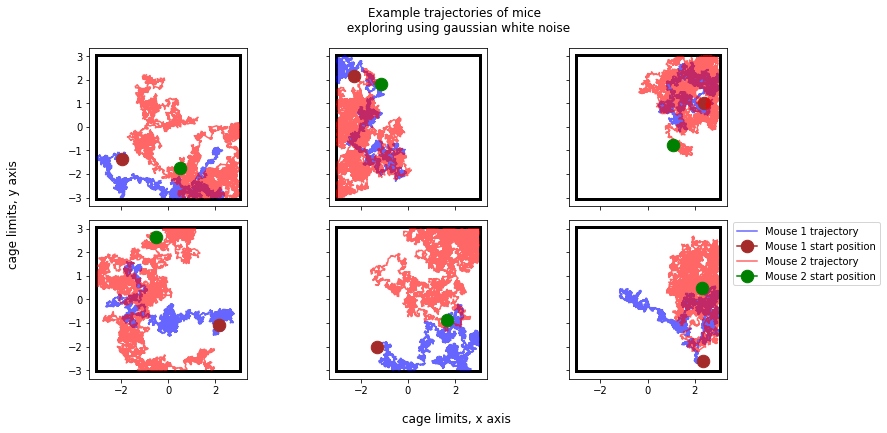

In [3]:
plot_example_exploration_trajectories()

#### Mating Model
Considering [P5](#P5) (mice need to reproduce) and [A5](#A5) (periodicity of mating period),
I chose as an appropriate model a model with 2 components.

##### Periodicity of mating desire

The first one takes into consideration the fact that mating desire is periodical.
For ease of implementation, I took $\sin(w_{mating} \cdot t)$  function.
The advantage of the sinusoidal function is that there is one parameter controlling
the periodicity and one for the start of the phase at the beginning os the simulation.

Sinusoidals also come with the advantage that they vary periodically in the interval [-1, 1].
In our case, the value 1 represents the fact that the two mice are attracting each other and -1 the
fact that the mice are currently avoiding each other (i.e. condition [P2](#P2)).

##### Mating desire

I want to take into consideration the fact that mice are aroused with increased intensity as the other mouse is
present in the vicinity.

As a consequence, I chose as an appropriate description a potential well of Gaussian shape.
When mating, from the perspective of the first mouse, there is an energy landscape with the lowest energy value
pointing to the other mouse.
The second mouse is, of course, handled symetrically.

The mating model thus looks like:

$$E_{mating} = \sin (w_{mating}t)\cdot \exp (-\dfrac {\left \| \vec{m_{1}} -\vec{m_{2}}\right \|^2}{\sigma_{mating} ^2 })$$


This produces, from the perspective of mouse 1, the following energy landscape when avoiding each other:

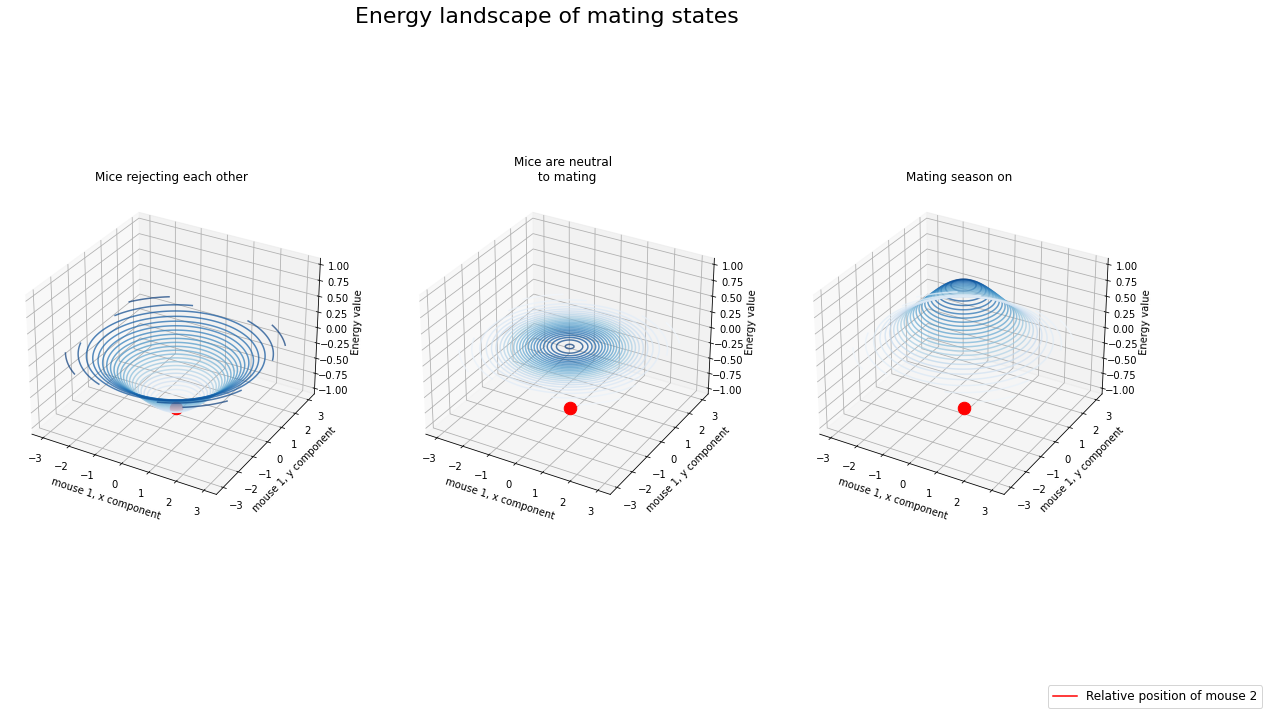

In [4]:
plot_mating_energy_landscape(figsize=(20,10))


As mentioned before, the dynamics of the system is to do gradient descent on this energy landscape

The gradient of mouse 1 then looks like:

$$\frac{\partial {E_{mating}} }{\partial \vec{m1}}=(-1) \cdot \sin (w_{mating}t) \cdot \frac {2}{\sigma_{mating} ^2} \cdot (\vec {m_1} - {\vec {m_2}})
\cdot \exp (-\dfrac {\left \| \vec{m_{1}} -\vec{m_{2}}\right \|^2}{\sigma_{mating} ^2 }) $$,
important being the fact that $\frac{\partial {E_{mating}}}{\partial \vec{m1}} \propto (\vec {m_1} - {\vec {m_2}}) $.

Depending on the value of $\sin (w_{mating}t)$ the system will either try to:

1. reduce the distance between $\vec{m_1}$ and $\vec{m_2}$ in case $\sin (w_{mating}t) = 1 $, due the leading -1

2. increase the distance between $\vec{m_1}$ and $\vec{m_2}$ in case $\sin (w_{mating}t) = -1 $, for the same reason

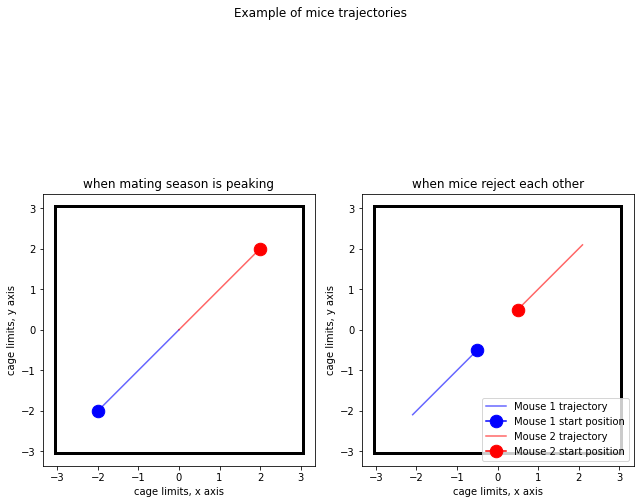

In [5]:
always_mating, always_rejecting = plot_mice_trajetories_for_mating_season_on_and_off()

One can also observe the evolution of the mating desire gradient length when mice
are closing in on each other.

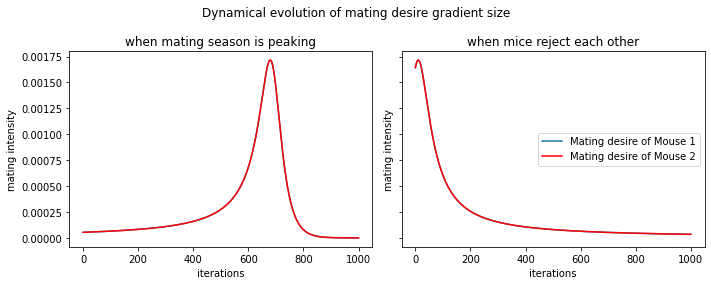

In [6]:
plot_mating_desire_gradients_for_mating_on_and_off(always_mating, always_rejecting)

As wanting to model, the closer
mice are to each other the higher the desire for mating.

#### Feeding Model

The feeding model is implemented with the same idea of an energy landscape as the **mating model** is.

Basically, I have modelled

$$E_{feeding} (t, \vec {m}) = {hunger_{max}} \cdot {\sigma}(t) \cdot || \vec {m} - \vec {food spot} || ^2$$

where

$$\sigma(t) = \frac {1} {1+ \exp(- \frac {t - (t_{lastfeeding} + 0.5 \cdot {t_{hunger}})}{slope})}$$

and $\vec {m}$ can be either $\vec {m_1}$ or $\vec {m_2}$ and $\vec {food spot}$ represents
the vector position of the center of the food spot considered from the centered of our
reference frame, the point $\vec {(0,0)}$

##### The strength of the hunger feeling

$\sigma(t)$ conveniently models how hungry a mouse is. I have chosen the sigmoidal function
because it can easily

1. model the fact that, with time, the mice get hungrier\
2. model the speed with which mice get hungrier by the parameter

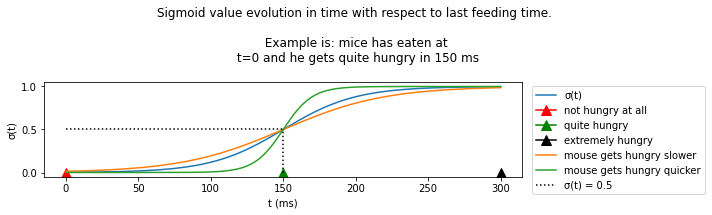

In [7]:
plot_sigmoid_function_output()

#### The gradient of the hunger feeling

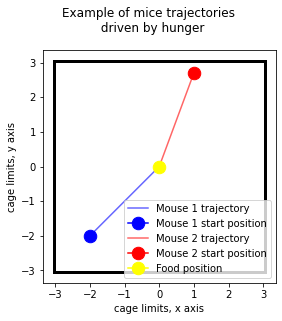

In [8]:
plot_feeding_example_trajectory()

### Implementation

The way the problem is declared allows me to split the problem into smaller ones.

## The Mice Model: combining all our simple models

$$ \tau_1\dot{\vec{m_1}} = \tau_1\frac{\vec{m_1}}{dt}= \sigma_{mouse}\cdot\xi(t) - \frac{\partial {E_{mating}} }{\partial \vec{m1}} - \frac{\partial {E_{feeding}} }{\partial \vec{m1}}
\newline
=\overbrace{\sigma_{mouse}\cdot\xi(t)}^{movement} - \underbrace{\sin (w_{mating}t) \cdot \frac {2}{\sigma_{mating} ^2} \cdot (\vec {m_1} - {\vec {m_2}})
\cdot \exp (-\dfrac {\left \| \vec{m_{1}} -\vec{m_{2}}\right \|^2}{\sigma_{mating} ^2 })}_{mating}
- \overbrace{{hunger_{max}} \cdot {\sigma}(t) \cdot || \vec {m_1} - \vec {food spot}||}^{feeding}
\newline
\tau_2\dot{\vec{m_2}}=\sigma_{2}\cdot\xi(t) - \sin (w_{mating}t) \cdot \frac {2}{\sigma_{mating} ^2} \cdot (\vec {m_2} - {\vec {m_1}})
\cdot \exp (-\dfrac {\left \| \vec{m_{2}} -\vec{m_{1}}\right \|^2}{\sigma_{mating} ^2 })
- hunger_{max} \cdot {\sigma}(t) \cdot || \vec {m_2} - \vec {food spot}||
$$




### Results

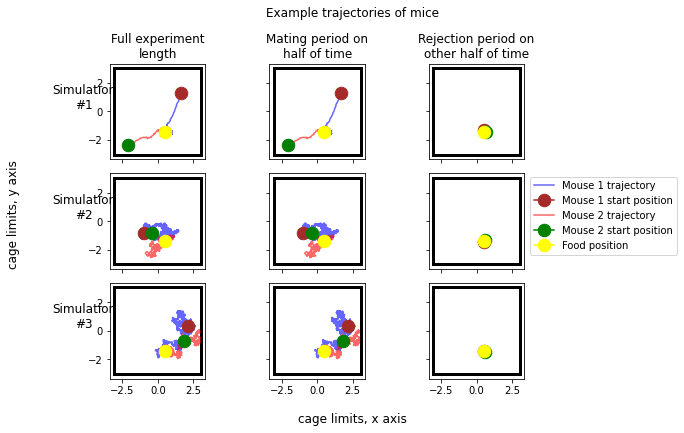

In [9]:
plot_example_full_trajectories()

## Discussion